In [95]:
import numpy as np #Working with arrays
import pandas as pd #working with the dataset from yfinance API
import yfinance as yf
import matplotlib.pyplot as plt #need some visualisation
from scipy import stats

#Build and train the model with pytorch
import torch
import torch.nn as nn
import torch.optim as optim

#Scale and evaluate our metric
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error

In [96]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [97]:
ticker = 'NVDA'
df = yf.download(ticker, '2020-01-01')

C:\Users\kaing\AppData\Local\Temp\ipykernel_27108\3604355685.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, '2020-01-01')
[*********************100%***********************]  1 of 1 completed


In [98]:
df

Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2020-01-02,5.971746,5.971746,5.892342,5.942872,237536000
2020-01-03,5.876163,5.919972,5.827126,5.852018,205384000
2020-01-06,5.900806,5.906034,5.756684,5.782820,262636000
2020-01-07,5.972243,6.018044,5.884127,5.929181,314856000
2020-01-08,5.983446,6.024766,5.927937,5.968013,277108000
...,...,...,...,...,...
2025-07-10,164.100006,164.500000,161.610001,164.320007,167704100
2025-07-11,164.919998,167.889999,163.470001,163.720001,193633300


<Axes: xlabel='Date'>

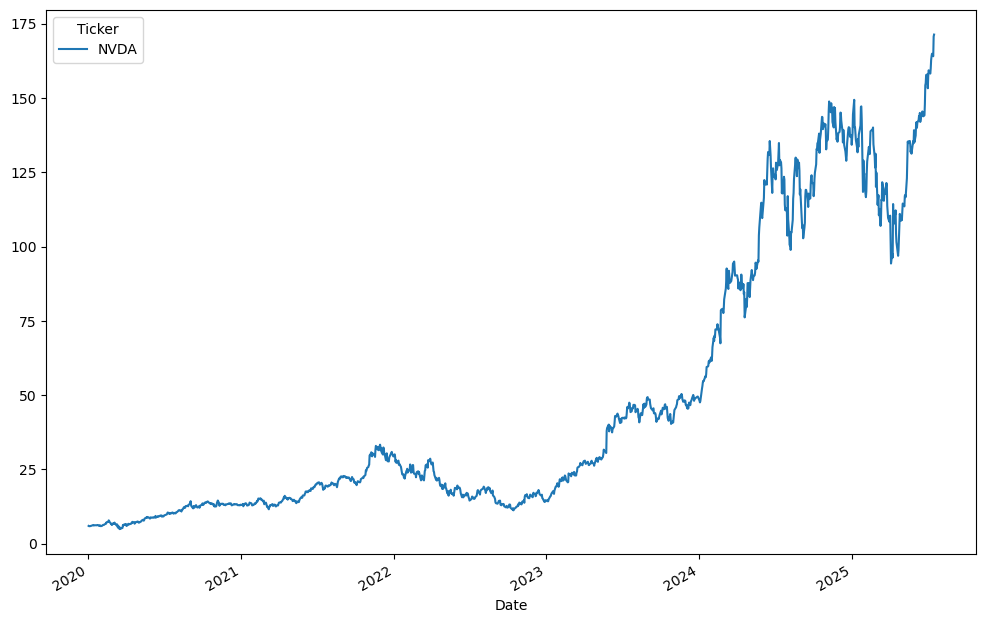

In [99]:
df.Close.plot(figsize=(12,8))

In [100]:
'''
fit_transform computes the min and max of the 'Close' column
Then, each value is scaled using x' = (x -min) / (max -min)
The result is that all values in 'Close' will be between 0 and 1 (unless you pass a custom range with feature_range=(a, b)).


Previously we used standard scaler:
scaler = StandardScaler()
df['Close'] = scaler.fit_transform(df['Close'])
Resulting values are centered around 0
Distribution has mean = 0 and std = 1

Example:
[100, 110, 120, 130, 140]

STANDARD SCALER: [-1.41, -0.71, 0.0, 0.71, 1.41]  # mean 0, std 1
MINMAXSCALER: [0.0, 0.25, 0.5, 0.75, 1.0]  # scaled between 0 and 1
'''

scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

In [101]:
df.Close

Ticker,NVDA
Date,
2020-01-02,0.006488
2020-01-03,0.005914
2020-01-06,0.006062
2020-01-07,0.006491
2020-01-08,0.006558
...,...
2025-07-10,0.956331
2025-07-11,0.961256
2025-07-14,0.956151


In [102]:
seq_length = 60 # n : How many days we want the LSTM model to look back to predict the next day
data = [] #Storing our input sequences


'''
This creates sliding windows of n consecutive days from the 'Close' prices.
For example:
i=0 → days 0 to 29 (predict day 29)
i=1 → days 1 to 30 (predict day 30)
So each item in data is a window of 30 days, where the first 29 are inputs and the 30th is the prediction target.
'''
for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)

#You use 80% of the data for training, the rest for testing.
#Better to split the data between training and test as we want our model to perform well under unseen data.
#If we do not split, the model might be too 'used' to the training data set ad will struggle in real world scenarios"
#In this case, we will do a 80:20 split but a 70:30 is also acceptable

#However, here want to introduce a 3-way split: training/validation/test
train_size = int(0.6 * len(data))    # 60% training
val_size = int(0.2 * len(data))      # 20% validation
test_size = len(data) - train_size - val_size  # 20% test

# Training data
X_train = torch.from_numpy(data[:train_size, :-1]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1]).type(torch.Tensor).to(device)

# Validation data
X_val = torch.from_numpy(data[train_size:train_size+val_size, :-1]).type(torch.Tensor).to(device)
y_val = torch.from_numpy(data[train_size:train_size+val_size, -1]).type(torch.Tensor).to(device)

# Test data
X_test = torch.from_numpy(data[train_size+val_size:, :-1]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size+val_size:, -1]).type(torch.Tensor).to(device)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Training samples: 798
Validation samples: 266
Test samples: 267


In [103]:
'''
PyTorch Neural Network -subclassing nn.Module
'''
class PredictionModel(nn.Module):


    '''
    __init__: 
    input_dim: Number of features per time step (1, since it's just "Close" price)
    hidden_dim: Size of the hidden state in the LSTM
    num_layers: Number of stacked LSTM layers
    output_dim: Output dimension (1, since we’re predicting one price value)
    dropout:Dropout is a regularization technique used in deep learning to prevent overfitting.

        -For example: dropout =0.2 ==> Randomly sets 20% of neurons to zero during training
    '''
    def __init__ (self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.2):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim


        #Defines an LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)

        #A fully connected layer to project the LSTM's output (from last time step) to the final prediction.
        #Add regularisation layers
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)


    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device) #initialises hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device) #initalises cell state

        #out contains all hidden states at each time step: shape (batch_size, seq_len, hidden_dim)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.dropout(out[:, -1, :]) # Dropout after LSTM
        out = torch.relu(self.fc1(out)) # Non-linear activation
        out = self.dropout(out) # Dropout before final layer
        out = self.fc2(out)  # Final prediction
        return out
    

In [104]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device) #module needs to be sent to GPU or the CPU

In [105]:
criterion = nn.MSELoss() #MEAN SQUARED ERROR
optimiser = optim.Adam(model.parameters(), lr=0.01) #Uses the Adam optimizer with a learning rate of 0.01 to update the model weights during training.

In [106]:
num_epochs = 200
best_val_loss = float('inf')
patience = 50  # Early stopping patience
patience_counter = 0

# Store losses for plotting
train_losses = []
val_losses = []

'''
This section is the training loop for your LSTM-based time-series prediction model.
it runs for num_epochs epochs and gradually reduces prediction error using gradient descent.

On each epoch, the model:
    Makes predictions
    Calculates how wrong they are (loss)
    Updates weights to do better next time
'''
for i in range(num_epochs):

    ###TRAINING STAGE:
    model.train()
    #Make the prediction: These are predictions for the 30th day based on the previous 29.
    y_train_pred = model(X_train)
    #We see how wrong is this prediction: Compares predicted prices with actual prices using MSELoss (mean squared error).
    train_loss = criterion(y_train_pred, y_train) # Lower loss = better prediction.

    ###VALIDATION STAGE:
    model.eval()
    with torch.no_grad():  # Disable gradient computation for validation (saves memory and computation)
        # Make predictions on validation data
        y_val_pred = model(X_val)
        
        # Calculate validation loss
        val_loss = criterion(y_val_pred, y_val)
    
    # Store losses for plotting
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    if i % 25 == 0:
         print(f'Epoch {i}: Train Loss: {train_loss.item():.6f}, Val Loss: {val_loss.item():.6f}')

        
    # Early stopping check:  keep the version of the model that performs best on the validation set.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {i}! Best validation loss: {best_val_loss:.6f}")
            break
    
    # Back to training mode for gradient updates
    model.train()
    '''
    #We back propogate the loss and tweak it to move in the correct direction

    optimiser.zero_grad()
    Clears any existing gradients from the previous step.

    loss.backward()
    Performs backpropagation: calculates how the model should change its weights to reduce error.

    optimiser.step()
    Updates the weights based on gradients, using the Adam optimizer.
    '''
    optimiser.zero_grad()
    train_loss.backward()
    optimiser.step()

    
print("Training completed!")

# Load the best model for final evaluation
model.load_state_dict(torch.load('best_model.pth'))
    

Epoch 0: Train Loss: 0.018491, Val Loss: 0.039452
Epoch 25: Train Loss: 0.001544, Val Loss: 0.092105
Epoch 50: Train Loss: 0.001045, Val Loss: 0.061721
Early stopping at epoch 50! Best validation loss: 0.039452
Training completed!


<All keys matched successfully>

In [107]:
'''
THAT WAS THE TRAINED MODEL, NOW LETS SEE THE HOW THE MODEL PERFORMS ON UNSEEN DATA
'''

#Tells the model it's in evaluation/inference mode (not training)
model.eval()

#Feeds the test data (X_test, i.e., sequences of past 29 days) into the trained model.Outputs predictions for the 30th day prices (scaled).
#Since we are evaluating, we do not need gradient ---> faster computation
with torch.no_grad():
    # Get predictions for all datasets
    y_train_pred = model(X_train)
    y_val_pred = model(X_val)
    y_test_pred = model(X_test)


'''
Previously, we scaled all price datausing the MinMaxScaler before training to bring it within a range of [0,1]
Now we are reversing that so we can interpret the predictions in actual price values (e.g., dollars).

For example:
original_prices = [100, 120, 130, 110, 115, 140]
scaled_prices that go into the neural network: [0.00, 0.25, 0.375, 0.50, 0.75, 1.00]

Lets say after training, the model predicts this on the test set:
y_test_pred_scaled = [[0.25], [0.5], [0.75]] <----- these outputs are still scaled

So we need convert them back into dollars($) and plot them
'''
# Convert predictions back to original scale
y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())

y_val_pred = scaler.inverse_transform(y_val_pred.detach().cpu().numpy())
y_val = scaler.inverse_transform(y_val.detach().cpu().numpy())

y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())



Final Results:
Training RMSE: 22.5658
Validation RMSE: 33.0667
Test RMSE: 90.0768


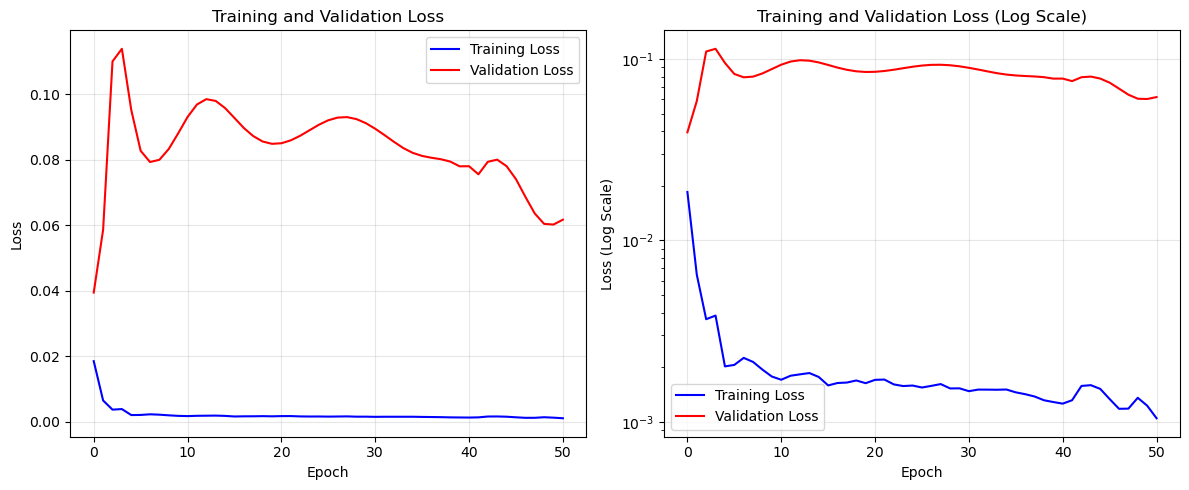


Performance Analysis:
Training vs Validation RMSE difference: 10.5010
Validation vs Test RMSE difference: 57.0101


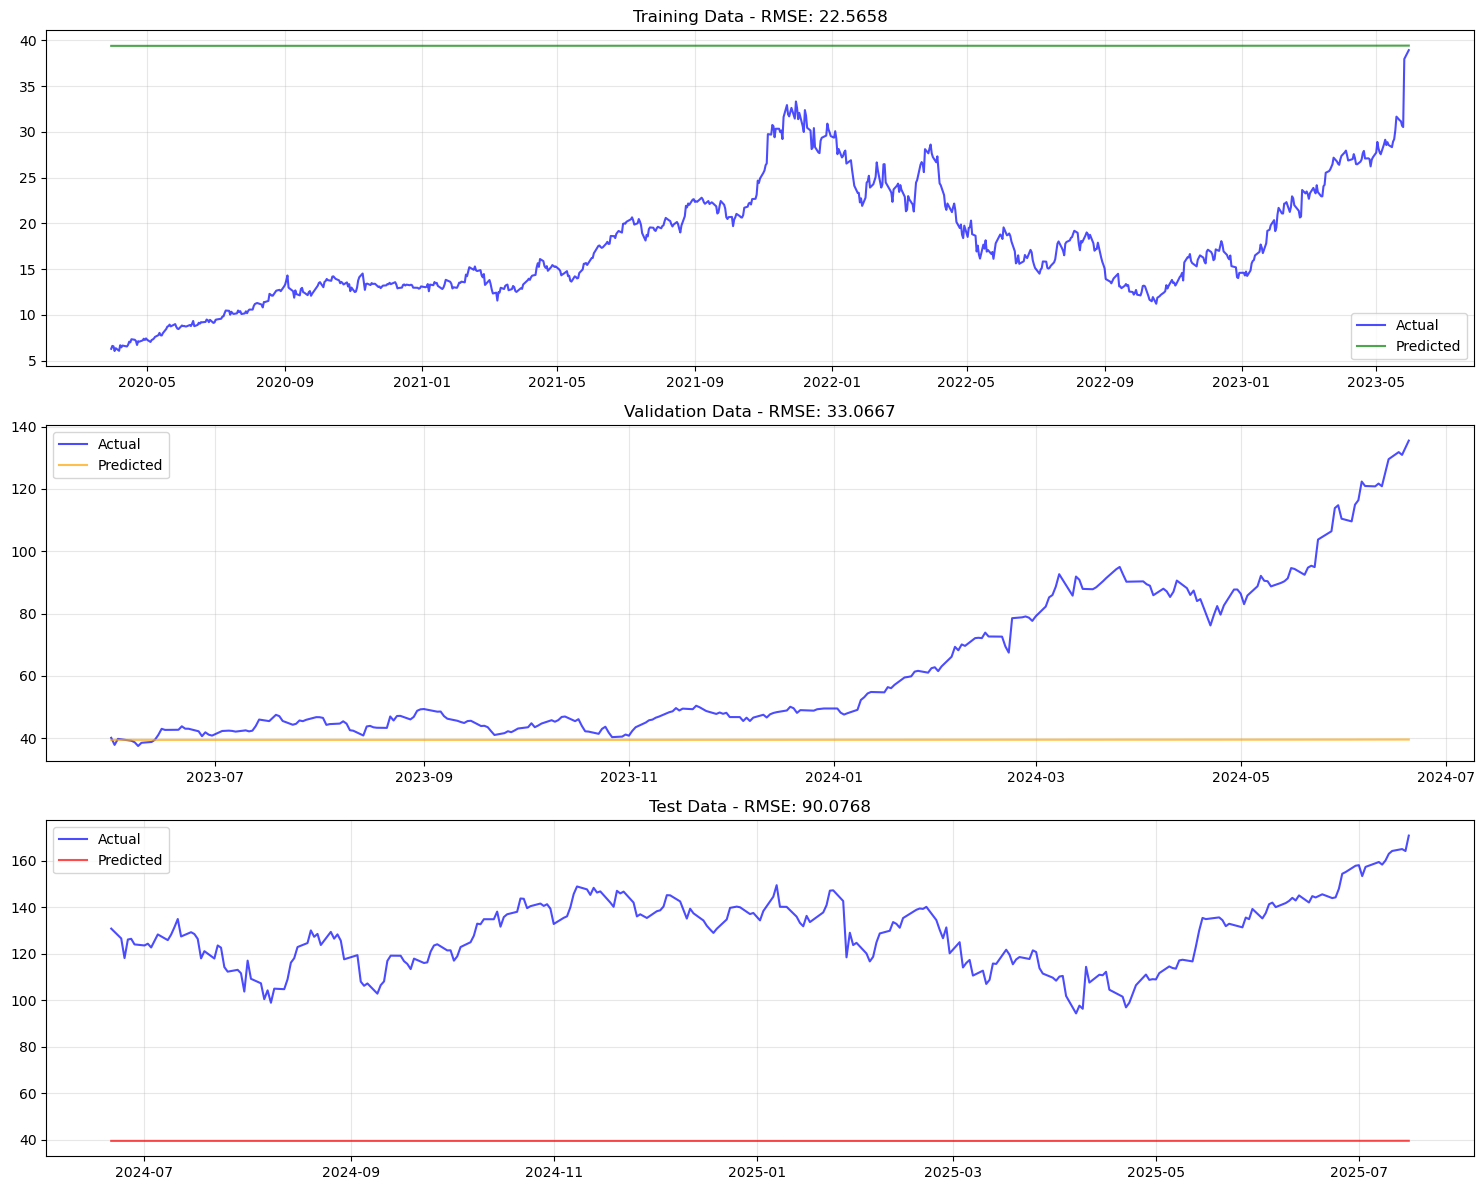

In [108]:
'''
Calculate the RMSE on both the training data, validation and test data sets
RMSE measures the average magnitude of the error between predicted and actual values:
Lower RMSE = better predictions
'''

train_rmse = root_mean_squared_error(y_train[:,0], y_train_pred[:, 0])
val_rmse = root_mean_squared_error(y_val[:,0], y_val_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:,0], y_test_pred[:, 0])

print(f"\nFinal Results:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss (Log Scale)')
plt.title('Training and Validation Loss (Log Scale)')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance comparison
print(f"\nPerformance Analysis:")
print(f"Training vs Validation RMSE difference: {abs(train_rmse - val_rmse):.4f}")
print(f"Validation vs Test RMSE difference: {abs(val_rmse - test_rmse):.4f}")

if train_rmse < val_rmse * 0.8:
    print("WARNING: Significant overfitting detected (train RMSE much lower than validation)")
elif val_rmse < test_rmse * 0.8:
    print("WARNING: Validation and test performance differ significantly")
else:
    print("Model performance looks consistent across datasets")

# Create comprehensive visualization for all datasets
fig, axes = plt.subplots(3, 1, figsize=(15, 12))




# Training data visualization
y_train_np = y_train.detach().cpu().numpy().squeeze() if hasattr(y_train, 'detach') else y_train.squeeze()
y_train_pred_np = y_train_pred.detach().cpu().numpy().squeeze() if hasattr(y_train_pred, 'detach') else y_train_pred.squeeze()

dates_train = df.iloc[seq_length:seq_length+len(y_train)].index
axes[0].plot(dates_train, y_train_np, color='blue', label='Actual', alpha=0.7)
axes[0].plot(dates_train, y_train_pred_np, color='green', label='Predicted', alpha=0.7)
axes[0].set_title(f'Training Data - RMSE: {train_rmse:.4f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validation data visualization
y_val_np = y_val.detach().cpu().numpy().squeeze() if hasattr(y_val, 'detach') else y_val.squeeze()
y_val_pred_np = y_val_pred.detach().cpu().numpy().squeeze() if hasattr(y_val_pred, 'detach') else y_val_pred.squeeze()

dates_val = df.iloc[seq_length+len(y_train):seq_length+len(y_train)+len(y_val)].index

axes[1].plot(dates_val, y_val_np, color='blue', label='Actual', alpha=0.7)
axes[1].plot(dates_val, y_val_pred_np, color='orange', label='Predicted', alpha=0.7)
axes[1].set_title(f'Validation Data - RMSE: {val_rmse:.4f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Test data visualization
y_test_np = y_test.detach().cpu().numpy().squeeze() if hasattr(y_test, 'detach') else y_test.squeeze()
y_test_pred_np = y_test_pred.detach().cpu().numpy().squeeze() if hasattr(y_test_pred, 'detach') else y_test_pred.squeeze()

dates_test = df.iloc[seq_length+len(y_train)+len(y_val):].index

axes[2].plot(dates_test, y_test, color='blue', label='Actual', alpha=0.7)
axes[2].plot(dates_test, y_test_pred, color='red', label='Predicted', alpha=0.7)
axes[2].set_title(f'Test Data - RMSE: {test_rmse:.4f}')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

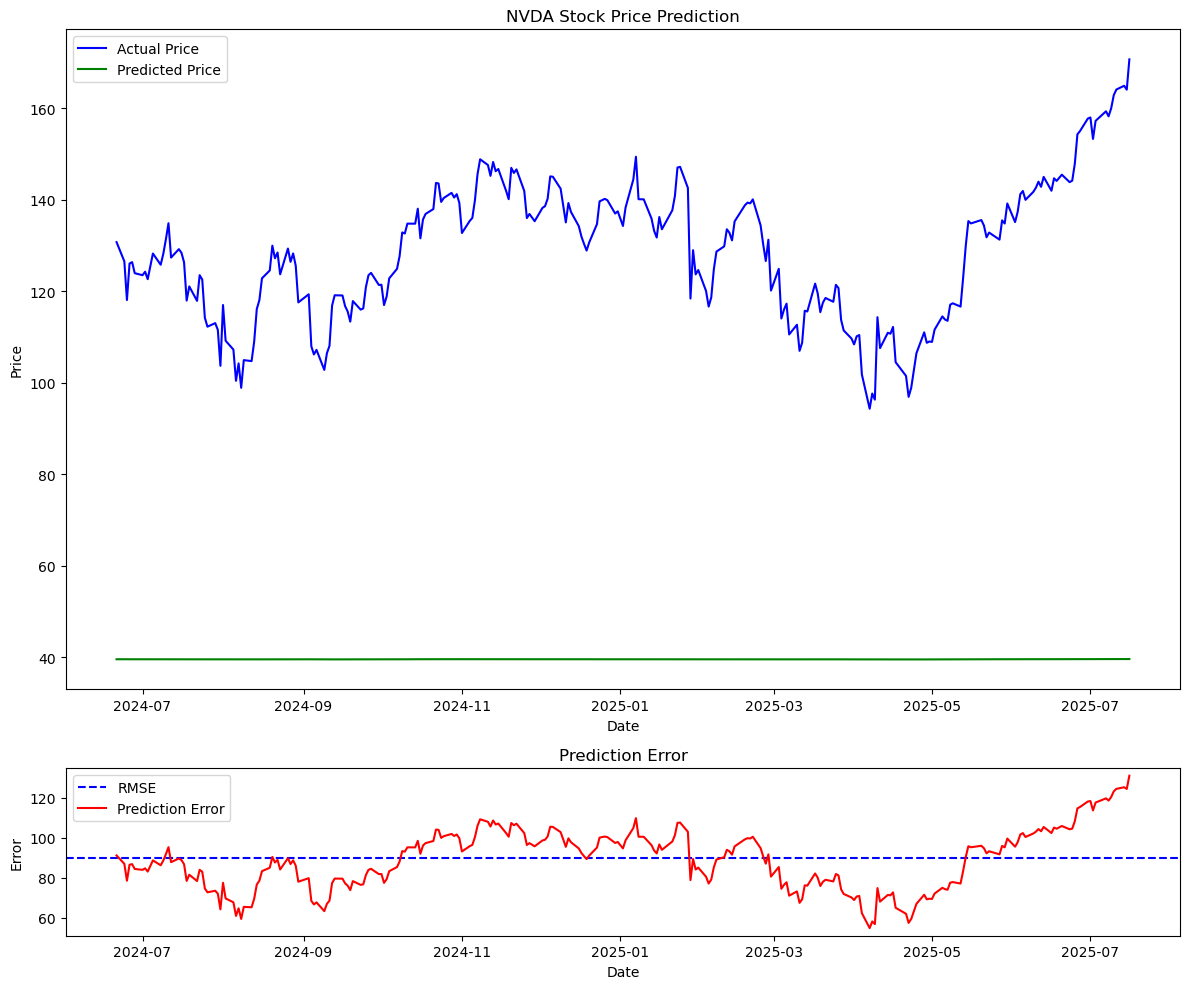

In [109]:
# Ensure predictions are numpy arrays
y_test_np = y_test.detach().cpu().numpy().squeeze() if hasattr(y_test, 'detach') else y_test.squeeze()
y_test_pred_np = y_test_pred.detach().cpu().numpy().squeeze() if hasattr(y_test_pred, 'detach') else y_test_pred.squeeze()

# Use numpy dates for x-axis
dates = df.iloc[-len(y_test_np):].index.to_numpy()

# Create figure and gridspec layout
fig = plt.figure(figsize=(12,10))
gs = fig.add_gridspec(4, 1)

# Plot actual vs predicted
ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(dates, y_test_np, color="blue", label='Actual Price')
ax1.plot(dates, y_test_pred_np, color="green", label='Predicted Price')
ax1.legend()
ax1.set_title(f"{ticker} Stock Price Prediction")
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')

# Plot error
ax2 = fig.add_subplot(gs[3, 0])
error = abs(y_test_np - y_test_pred_np)
ax2.axhline(test_rmse, color="blue", linestyle="--", label="RMSE")
ax2.plot(dates, error, color='red', label="Prediction Error")
ax2.legend()
ax2.set_title("Prediction Error")
ax2.set_xlabel("Date")
ax2.set_ylabel("Error")

plt.tight_layout()
plt.show()


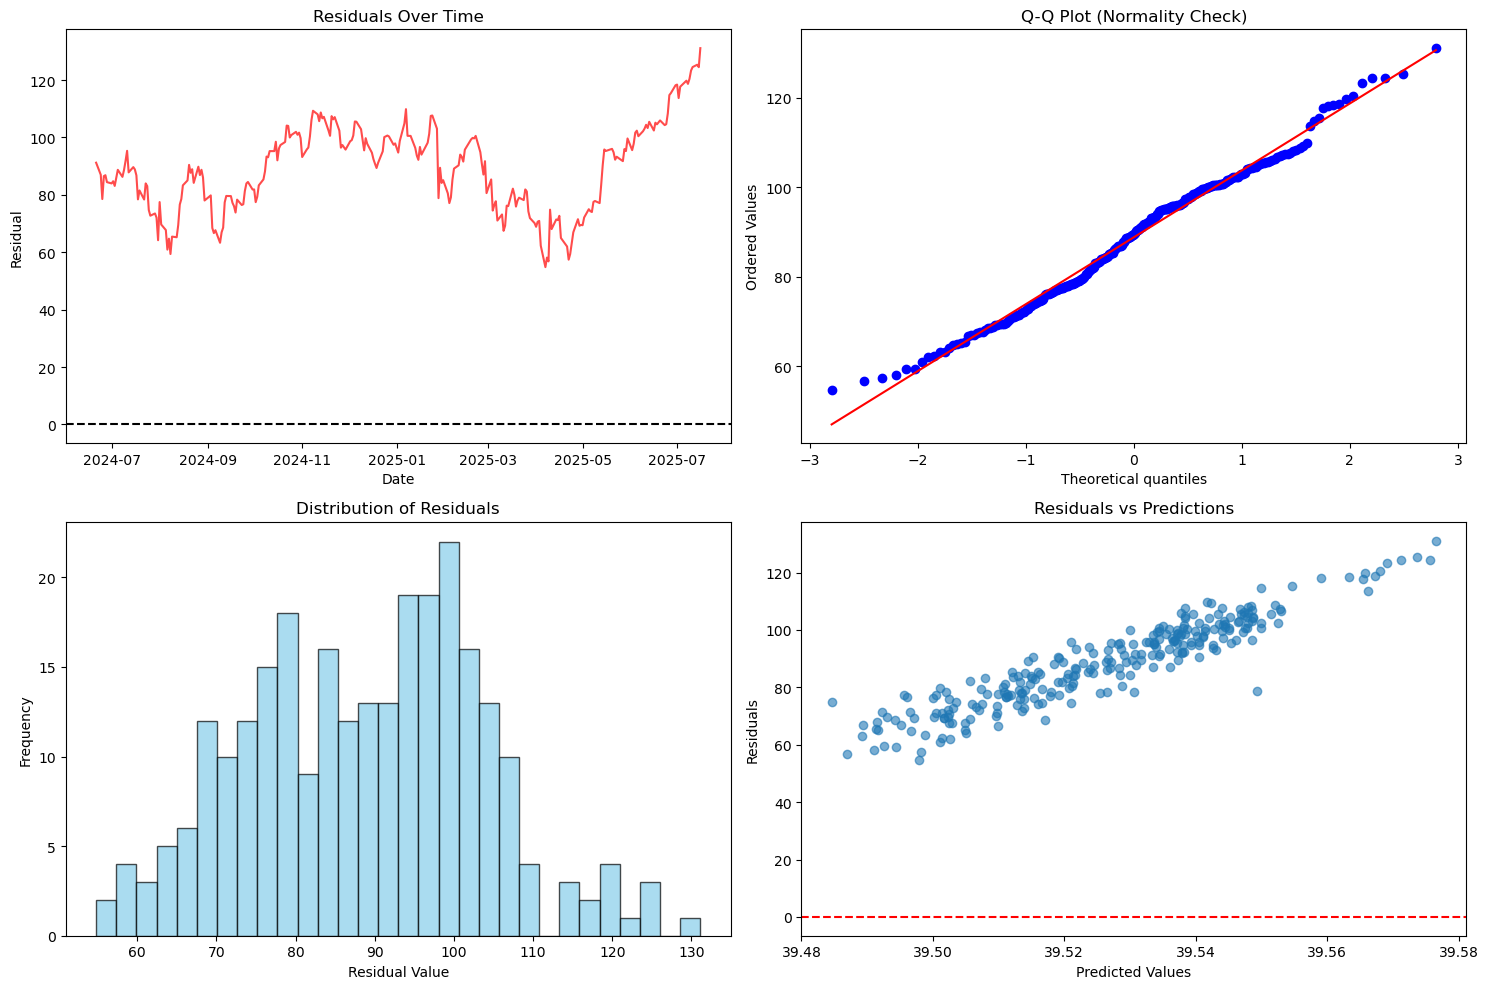

In [110]:
#Residual plots
def plot_residual_analysis(y_test_np, y_test_pred_np, dates):

    #Actual - predicted
    residuals = y_test_np - y_test_pred_np
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    # Residuals over time
    axes[0,0].plot(dates, residuals, color='red', alpha=0.7)
    axes[0,0].axhline(y=0, color='black', linestyle='--')
    axes[0,0].set_title('Residuals Over Time')
    axes[0,0].set_xlabel('Date')
    axes[0,0].set_ylabel('Residual')
    
    # Q-Q plot for normality
    stats.probplot(residuals, dist="norm", plot=axes[0,1])
    axes[0,1].set_title('Q-Q Plot (Normality Check)')
    
    # Histogram of residuals
    axes[1,0].hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1,0].set_title('Distribution of Residuals')
    axes[1,0].set_xlabel('Residual Value')
    axes[1,0].set_ylabel('Frequency')
    
    # Residuals vs Predictions (heteroscedasticity check)
    axes[1,1].scatter(y_test_pred_np, residuals, alpha=0.6)
    axes[1,1].axhline(y=0, color='red', linestyle='--')
    axes[1,1].set_title('Residuals vs Predictions')
    axes[1,1].set_xlabel('Predicted Values')
    axes[1,1].set_ylabel('Residuals')
    
    plt.tight_layout()
    plt.show()

plot_residual_analysis(y_test_np, y_test_pred_np, dates)
    
